## Описание проекта

Главная задача проекта: поиск изображения по запросу. Нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

При решении данной задачи будем использовать фреймворк PyTorch.

### Загрузка данных

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as t_models
import torchvision.transforms as t_transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error
from scipy import spatial
from transformers import BertTokenizer, BertModel

import nltk
import os
import re
import random
from tqdm import tqdm as tqdm
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [ ]:
torch.cuda.is_available()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# colab_path = 'drive/MyDrive/project'

In [ ]:
# %cd 'drive/MyDrive/fourth_project'
# !pwd

In [ ]:
np.random.seed(42)

In [ ]:
train_dataset = pd.read_csv('train_dataset.csv')
crowd_annos = pd.read_table('CrowdAnnotations.tsv', header=None)
expert_annos = pd.read_table('ExpertAnnotations.tsv', header=None)
test_queries = pd.read_csv('test_queries.csv', delimiter='|', index_col=0)

In [ ]:
train_dataset.head(3)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...

In [ ]:
crowd_annos.head(2)

0                            1    2  3  4
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  1.0  3  0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  0.0  0  3

In [ ]:
crowd_annos.columns = ['image',
                      'query_id',
                      'frac_proved',
                      'num_proved',
                      'num_not_proved']

In [ ]:
expert_annos.head(2)

0                            1  2  3  4
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  1  1  1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  1  1  2

In [ ]:
expert_annos.columns = ['image',
                       'query_id',
                       'score1','score2','score3']

In [ ]:
test_queries.head(2)

query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg

### Предобработка данных

#### Пропущенные значения

In [ ]:
expert_annos.isna().sum()

image       0
query_id    0
score1      0
score2      0
score3      0
dtype: int64

In [ ]:
crowd_annos.isna().sum()

image             0
query_id          0
frac_proved       0
num_proved        0
num_not_proved    0
dtype: int64

In [ ]:
train_dataset.isna().sum()

image         0
query_id      0
query_text    0
dtype: int64

In [ ]:
test_queries.isna().sum()

query_id      0
query_text    0
image         0
dtype: int64

#### Дубликаты

In [ ]:
expert_annos[['image', 'query_id']].duplicated().sum()

0

In [ ]:
crowd_annos[['image', 'query_id']].duplicated().sum()

0

#### Аггрегирование оценки

На данном шаге нужно сделать аггрегацию оценок экспертов и краудсорсинговой фирмы и объединить их так, чтобы данная целевая переменная была в `[0,1]`. То есть отражала, насколько изображение подходит под описание

`ExpertAnnotations`

Каждую пару оценивали 3 эксперта. Сделаем так: если хотя бы 2 оценки совпадают, то берем по большинству. В противном случае, когда все разные, возьмем среднее арифметическое и окргулим. Затем нормализуем значения к [0,1]

In [ ]:
def expert_annos_func(row):
    row = row[['score1', 'score2', 'score3']]
    if len(set(row)) == len(row):
        return round(np.sum(row) / 3)
    return np.sort(row)[1]

In [ ]:
expert_annos['final_score'] = expert_annos[['score1',
                                            'score2',
                                            'score3']].apply(expert_annos_func, axis=1)

In [ ]:
expert_annos.drop(columns=['score1', 'score2', 'score3'], inplace=True, axis=1)

In [ ]:
exp_min = expert_annos['final_score'].min()
exp_max = expert_annos['final_score'].max()

expert_annos['final_score'] = (expert_annos['final_score'] - exp_min) / (exp_max - exp_min)

In [ ]:
expert_annos['final_score'].value_counts()

final_score
0.000000    3327
0.333333    1666
0.666667     518
1.000000     311
Name: count, dtype: int64

`CrowdAnnotations`

Здесь выбираем долю подтвердивших, значения уже в подходящем интервале [0,1]

In [ ]:
crowd_annos['frac_proved'].value_counts()

frac_proved
0.000000    41970
0.333333     3000
0.666667     1360
1.000000     1323
0.250000       96
0.500000       27
0.200000       22
0.750000        9
0.600000        8
0.400000        8
0.800000        4
0.166667        3
Name: count, dtype: int64

In [ ]:
crowd_annos.rename(columns={'frac_proved':'final_score'}, inplace=True)
crowd_annos.drop(columns=['num_proved', 'num_not_proved'], inplace=True)

`Объединение оценок`

In [ ]:
expert_annos.shape, crowd_annos.shape

((5822, 3), (47830, 3))

In [ ]:
se, sc = set(expert_annos['image']), set(crowd_annos['image'])

In [ ]:
len(se), len(sc)

(1000, 1000)

In [ ]:
print(len(se.intersection(sc)))

1000


Получается, что эксперты и краудсорсинговая компания размечали одинаковое множество фотографий, но количество описаний под каждую фотографию отличается.

Теперь нужно привести экспертные и краудсорсинговые оценки к единому целому. Воспользуемся такой формулой: `expert * 0.65 + crowd * 0.35` и объедними таблицы воедино. Такая оценка будет справедлива, если пару (изображение-описание) оценивали обе стороны. Для пар, которые были оценены только краудсорсинговой фирмой оставим эту оценку и наоборот

In [ ]:
annos = pd.merge(
    expert_annos, crowd_annos,
    on=['image', 'query_id'],
    how='outer',
    suffixes=('_exp','_cwd')
)

In [ ]:
annos.shape

(51323, 4)

In [ ]:
annos.head()

image                     query_id  final_score_exp  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         0.000000   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         0.000000   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2         0.000000   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2         0.333333   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2         0.000000   

   final_score_cwd  
0              0.0  
1              0.0  
2              NaN  
3              NaN  
4              NaN

In [ ]:
annos['final_score_exp'].isna().sum(), annos['final_score_cwd'].isna().sum()

(45501, 3493)

In [ ]:
annos.dropna(thresh=3, inplace=True)

In [ ]:
annos.shape

(51323, 4)

In [ ]:
annos.fillna(0, inplace=True)

In [ ]:
def score_func(row):
    '''At least one parameter wasn`t Nan'''
    exp = row['final_score_exp']
    cwd = row['final_score_cwd']
    if exp == 0:
        return cwd
    if cwd == 0:
        return exp
    return exp * 0.65 + cwd * 0.35

annos['score'] = annos.apply(score_func, axis=1)

In [ ]:
t = pd.DataFrame(data=annos['score'].value_counts())
t.head()

count
score          
0.000000  43659
0.333333   2747
0.333333   1552
1.000000   1291
0.666667   1202

In [ ]:
annos.shape

(51323, 5)

In [ ]:
annos.drop(columns=['final_score_exp', 'final_score_cwd'], inplace=True)

Получили почти 51K записей. Добавим сюда соответствующие описания, из `train_dataset`

In [ ]:
data_merged = pd.merge(train_dataset[['query_id', 'query_text','image']],
             annos, how='right', on=['image','query_id'])

In [ ]:
data_merged.shape

(51323, 4)

In [ ]:
data_merged.isna().sum()

query_id          0
query_text    45501
image             0
score             0
dtype: int64

В `query_text` 45501 пропуск, и очевидно, что существуют `query_text`, которые можно отобразить по соответствующим `query_id`, остальное нужно удалить

In [ ]:
tmp_query = data_merged[['query_id','query_text']]
tmp_query = tmp_query[tmp_query['query_text'] == tmp_query['query_text']]
d_query = pd.Series(tmp_query.query_text.values, index=tmp_query.query_id).to_dict()

def fill_qtext(x):
    if pd.isnull(x['query_text']) and x['query_id'] in d_query.keys():
        x['query_text'] = d_query[x['query_id']]
    return x

data_merged = data_merged.apply(fill_qtext, axis=1)

In [ ]:
data_merged.isna().sum()

query_id         0
query_text    1109
image            0
score            0
dtype: int64

In [ ]:
data_merged.dropna(subset='query_text', inplace=True)

### Проверка данных

Теперь необходимо исключить из материалов те, которые содержат лиц младше 16 лет. По описанию изображения

In [ ]:
stop_words = ['child', 'young', 'baby',
              'children', 'kid', 'kids',
             'little', 'girl', 'boy']

In [ ]:
def remove_punct_and_lower(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = " ".join(list(map(lambda x: x.lower(), text.split())))
    return text

def filter_(text, remove=True):
    text = text['query_text']
    if remove:
        text = remove_punct_and_lower(text)
    for word in text.split(" "):
        if word in stop_words:
            return True
    return False

In [ ]:
#bad comments
comments = data_merged[['query_id', 'query_text']]
remove_suffix = lambda x: x['query_id'].rsplit("#", 1)[0]
comments['query_id'] = comments.apply(remove_suffix, axis=1)

comments['is_vorbidden'] = comments.apply(filter_, axis=1)
bad_images = set(comments[comments['is_vorbidden']]['query_id'])

In [ ]:
len(bad_images)

264

In [ ]:
fin = lambda x: True if x['image'] in bad_images else False
data_merged['del'] = data_merged.apply(fin, axis=1)

In [ ]:
data_merged['del'].sum()

13035

In [ ]:
data_merged = data_merged[data_merged['del'] == False]
data_merged.drop(columns=['del', 'query_id'], inplace=True)

In [ ]:
data_merged.shape

(37179, 3)

Провели очистку данных от детских изображений. Итого: мы получили готовый тренировачный датасет. Общее кол-во сэмплов ~37K

### Векторизация текстов (Bert)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from tqdm.notebook import tqdm
model_id = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_id)
model_bert = BertModel.from_pretrained(model_id).to(device)

In [ ]:
tokenized = data_merged['query_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True,
                               truncation=True)
)

max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
attention_mask = np.where(padded != 0, 1, 0)

In [ ]:
padded.shape[0]

37179

In [ ]:
batch_size = 100
embeddings = None

for i in tqdm(range(padded.shape[0] // batch_size)):
    batch = torch.cuda.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.cuda.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
    if embeddings is None:
        embeddings = batch_embeddings[0][:,0,:]
    else:
        embeddings = torch.cat((embeddings, batch_embeddings[0][:,0,:]), 0)
rest_batch = torch.cuda.LongTensor(padded[(padded.shape[0] // batch_size) * batch_size:])
rest_att_mask = torch.cuda.LongTensor(attention_mask[(padded.shape[0] // batch_size) * batch_size:])
with torch.no_grad():
    batch_embeddings = model_bert(rest_batch, attention_mask=rest_att_mask)
    if embeddings is None:
        embeddings = batch_embeddings[0][:,0,:]
    else:
        embeddings = torch.cat((embeddings, batch_embeddings[0][:,0,:]), 0)

  0%|          | 0/371 [00:00<?, ?it/s]

In [ ]:
type(embeddings), embeddings.shape

(torch.Tensor, torch.Size([37179, 768]))

### Векторизация текстов

In [ ]:
nltk.download("stopwords")
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Igor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
tfidf = TfidfVectorizer(smooth_idf=True, use_idf=True,
                        stop_words=list(stopwords), ngram_range=(1,1))

corpus_train = data_merged['query_text']
tfidf_train = tfidf.fit_transform(corpus_train)

In [ ]:
df_idf = pd.DataFrame(data=tfidf.idf_,
                 index=tfidf.get_feature_names_out(),
                 columns=['idf_weights'])
df_idf.sort_values(by=['idf_weights'], ascending=False).head(7)

idf_weights
teenagers      9.914088
scrambling     9.914088
net            9.914088
biting         9.444085
kitten         9.444085
slippery       9.444085
hay            9.326302

Теперь сами описания нам не нужны в `data_merged`

In [ ]:
data_merged.drop(columns=['query_text'], inplace=True)

In [ ]:
print("Размер матриц")
print(f"Train TfIdf: {tfidf_train.shape}")

Размер матриц
Train TfIdf: (37179, 1436)


### Векторизация изображений

Нужно сделать собственный класс `ImageDataset` и затем `DataLoader`, иначе сет не зайдет в RAM

In [ ]:
class ImageDataset(torch.utils.data.Dataset):

    def __init__(self, loc, transform=None):
        self.transform = transform
        self.paths = np.array([os.path.join(loc, i) \
                               for i in os.listdir(loc) if i.endswith('.jpg')])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = torchvision.datasets.folder.default_loader(path)

        if self.transform is not None:
            img = self.transform(img)
        return path, img

In [ ]:
batch_size = 25
def collate_fn(batch):
    return tuple(batch)

def cr_custom_dl(loc):
    scaler = t_transforms.Resize(size=(224, 224))
    normalizer = t_transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
    to_tensor = t_transforms.ToTensor()

    transformations = t_transforms.Compose([
        scaler,
        to_tensor,
        normalizer
    ])
    images_ds = ImageDataset(loc, transformations)
    images_dl = torch.utils.data.DataLoader(images_ds, num_workers=0,
                                           batch_size=batch_size, shuffle=False,
                                           drop_last=False, collate_fn=collate_fn)
    return images_dl

In [ ]:
class InfoEmbeddings:

    def __init__(self):
        self.embeddings = None  #embeddings itself
        self.filename_to_index = {}   #appropriate index in hidden array

    def add_embedding(self, fname, output):
        if self.embeddings is None:
            self.embeddings = np.array(output.detach().cpu().numpy())
        else:
            self.embeddings = np.vstack([
                self.embeddings,
                output.detach().cpu().numpy()
            ])

        self.filename_to_index[fname] = len(self.embeddings) - 1

    def get_embedding(self, fname, is_train=True):
        '''Input: filename in local dir
           Output: vector-feature
        '''
        if is_train:
            prefix = 'train_images/'
        else:
            prefix = 'test_images/'
        if not fname.startswith(prefix):
            fname = prefix + fname
        index = self.filename_to_index[fname]
        return self.embeddings[index]

In [ ]:
model_ext = t_models.resnet50(weights='DEFAULT').to(device)
model_ext.fc = nn.Identity()

model_ext.eval()
custom_dl = cr_custom_dl('train_images/')
img_emb_info = InfoEmbeddings()

In [ ]:
for i, data in enumerate(custom_dl):
    for j in range(batch_size):
        fname = data[j][0]
        sample = Variable(data[j][1].unsqueeze(0)).to(device)
        emb = model_ext(sample)
        img_emb_info.add_embedding(fname, emb)

In [ ]:
img_emb_info.embeddings.shape

(1000, 2048)

#### Объединение векторов текста и векторов изображений

В этом разделе мы объединим полученные эмбеддинги воедино, а также добавим целевую переменную, то есть итоговую оценку сходства

In [ ]:
tfidf_train = tfidf_train.toarray()
print("Shape of text embeddings (TfIdf)", tfidf_train.shape)
print("Shape of text embeddings (Bert)", embeddings.shape)
print("Shape of image embeddings", img_emb_info.embeddings.shape)

Shape of text embeddings (TfIdf) (37179, 1436)
Shape of text embeddings (Bert) torch.Size([37179, 768])
Shape of image embeddings (1000, 2048)


In [ ]:
data_merged.head(3)

image  score
0  1056338697_4f7d7ce270.jpg    0.0
1  1056338697_4f7d7ce270.jpg    0.0
2  1056338697_4f7d7ce270.jpg    0.0

In [ ]:
embeddings.shape, data_merged.shape

(torch.Size([37179, 768]), (37179, 2))

In [ ]:
data_merged = np.hstack([data_merged.values, embeddings.cpu()])

In [ ]:
data_merged

array([['1056338697_4f7d7ce270.jpg', 0.0, -0.047877777367830276, ...,
        0.020952517166733742, 0.3236025273799896, 0.6049586534500122],
       ['1056338697_4f7d7ce270.jpg', 0.0, 0.30646079778671265, ...,
        -0.19275614619255066, 0.1811203509569168, 0.577595055103302],
       ['1056338697_4f7d7ce270.jpg', 0.0, 0.22594526410102844, ...,
        -0.3192073702812195, 0.4300093352794647, 0.24305550754070282],
       ...,
       ['997722733_0cb5439472.jpg', 1.0, 0.012549434788525105, ...,
        -0.27696847915649414, 0.07785482704639435, 0.26698994636535645],
       ['997722733_0cb5439472.jpg', 0.0, -0.5180827379226685, ...,
        -0.4747435450553894, 0.03497857600450516, 0.21260064840316772],
       ['997722733_0cb5439472.jpg', 0.666666666666667,
        -0.31907790899276733, ..., -0.1746087670326233,
        0.28301867842674255, -0.03104110062122345]], dtype=object)

Теперь нужно присоединить вектор эмбеддинги изображений

In [ ]:
emb_list = None
fnames = data_merged[:, 0]

for fname in tqdm(fnames):
    if emb_list is None:
        emb_list = img_emb_info.get_embedding(fname)
    else:
        emb_list = np.vstack([emb_list, img_emb_info.get_embedding(fname)])

data_merged = np.hstack([data_merged, emb_list])

  0%|          | 0/37179 [00:00<?, ?it/s]

In [ ]:
data_merged.shape

(37179, 2818)

### Разделение данных

In [ ]:
test_set = set(test_queries['image'])
train_set = set(train_dataset['image'])
train_set.intersection(test_set)

set()

In [ ]:
def get_sets(data, train_ind, valid_ind):
    '''data is pd.DF without images'''
    xy_train = data[train_ind, :]
    xy_valid = data[valid_ind, :]

    X_train = np.delete(xy_train, obj=0, axis=1).astype('float64')
    X_valid = np.delete(xy_valid, obj=0, axis=1).astype('float64')
    y_train = xy_train[:, 0].reshape(-1, 1).astype('float64')
    y_valid = xy_valid[:, 0].reshape(-1, 1).astype('float64')

    X_train = torch.FloatTensor(X_train).to(device)
    X_valid = torch.FloatTensor(X_valid).to(device)
    y_train = torch.FloatTensor(y_train).to(device)
    y_valid = torch.FloatTensor(y_valid).to(device)

    return X_train, X_valid, y_train, y_valid

In [ ]:
gss = GroupShuffleSplit(n_splits=10,
                       train_size=0.75)

df_no_imgs = np.delete(data_merged, obj=0, axis=1)
only_imgs = data_merged[:, 0]

### Выбор метрики

Была выбрана метрика MeanAbsoluteError, так как это единственный разумный вариант для нашей задачи. Значение вероятности находятся в [0,1] и поэтому MAE будет напрямую отражать качество предсказаний

### Выбор моделей и их обучение

У нас будут 2 модели: линейная регрессия и полносвязная нейронная сеть. В качестве Baseline возьмем DummyRegressor и будем сравнивать с ним

`DummyRegressor`

In [ ]:
yield_ind_dummy = gss.split(X=df_no_imgs[:,:],\
                    y=df_no_imgs[:,0],\
                    groups=only_imgs)

In [ ]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_mae = []

for train_indices, valid_indices in tqdm(yield_ind_dummy):
    X_train, X_valid, y_train, y_valid = get_sets(df_no_imgs, train_indices, valid_indices)

    dummy_regr.fit(X_train.cpu(), y_train.cpu())
    pred = dummy_regr.predict(X_valid.cpu())

    loss = mean_absolute_error(y_valid.cpu().reshape(1,-1).squeeze(0), pred)
    dummy_mae.append(loss)

10it [00:44,  4.49s/it]


`Linear Regression`

In [ ]:
yield_ind_lreg = gss.split(X=df_no_imgs[:,:],\
                    y=df_no_imgs[:,0],\
                    groups=only_imgs)

In [ ]:
lin_reg = LinearRegression()
lreg_mae = []

for train_indices, valid_indices in tqdm(yield_ind_lreg):
    X_train, X_valid, y_train, y_valid = get_sets(df_no_imgs, train_indices, valid_indices)

    lin_reg.fit(X_train.cpu(), y_train.cpu())
    pred = lin_reg.predict(X_valid.cpu())

    #loss = mean_absolute_error(y_valid.cpu(), pred)
    loss = mean_absolute_error(y_valid.cpu().reshape(1,-1).squeeze(0),
                               pred.reshape(1,-1).squeeze(0))
    lreg_mae.append(loss)

10it [02:13, 13.36s/it]


`Fully connected NN`

In [ ]:
class ImageTextLikeNet(nn.Module):

    def __init__(self, input_shape):
        super(ImageTextLikeNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=400),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=400, out_features=200),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=200, out_features=50),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=50, out_features=1),
            nn.Sigmoid()
        )

        self.init_start_weights()  # init weights

    def forward(self, X):
        return self.model(X)

    def init_start_weights(self):
        for layer in self.model:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_normal_(layer.weight)

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X, self.y = X, y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
gss_nn = GroupShuffleSplit(n_splits=1,
                       train_size=0.75)

df_no_imgs_ = np.delete(data_merged, obj=0, axis=1)
only_imgs_ = data_merged[:, 0]
yield_ind_ = gss.split(X=df_no_imgs[:,:],\
                    y=df_no_imgs[:,0],\
                    groups=only_imgs)
train_indices_, valid_indices_ = next(yield_ind_)
X_train_, X_valid_, y_train_, y_valid_ = get_sets(df_no_imgs_,
                                                  train_indices_, valid_indices_)

In [ ]:
train_indices.shape, valid_indices.shape

((27771,), (9408,))

In [ ]:
learning_rate = 0.0005
batch_size = 25
epochs = 10
input_shape = df_no_imgs.shape[1] - 1

#Dataloaders
train_dataset = CustomDataset(X_train_, y_train_)
valid_dataset = CustomDataset(X_valid_, y_valid_)
train_dataloader = DataLoader(train_dataset, batch_size=25, num_workers=0, shuffle=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=25, num_workers=0, shuffle=False)

model = ImageTextLikeNet(input_shape).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.L1Loss()
#loss_fn = nn.CosineEmbeddingLoss()

In [ ]:
def train_loop(dataloader, model, loss_fn, optim):
    model.train()

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        #target = Variable(torch.Tensor(pred.size(0)).cuda().fill_(1.0)).to(device)
        loss = loss_fn(pred, y)

        #Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 50 == 0 or batch == size - 1:
            loss, counter = loss.item(), len(X) * (batch + 1)
            print(f"loss: {loss:>7f}  [{counter:>5d}/{size:>5d}]")

In [ ]:
nn_mae = []
def validate_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    valid_loss= 0

    with torch.no_grad():
        for X,y in dataloader:
            pred = model(X)
            #target = Variable(torch.Tensor(pred.size(0)).cuda().fill_(1.0)).to(device)
            valid_loss += loss_fn(pred, y).item()
            nn_mae.append(loss_fn(pred, y).item())
    valid_loss /= num_batches
    print(f"Valid_error:\n    Avg loss: {valid_loss:>8f} \n")

In [ ]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    validate_loop(valid_dataloader, model, loss_fn)
print("End!")

Epoch 1
-------------------------------
loss: 0.415854  [   25/27978]
loss: 0.302252  [ 1275/27978]
loss: 0.171853  [ 2525/27978]
loss: 0.106659  [ 3775/27978]
loss: 0.000003  [ 5025/27978]
loss: 0.173375  [ 6275/27978]
loss: 0.026669  [ 7525/27978]
loss: 0.026654  [ 8775/27978]
loss: 0.000001  [10025/27978]
loss: 0.053334  [11275/27978]
loss: 0.013340  [12525/27978]
loss: 0.040001  [13775/27978]
loss: 0.080019  [15025/27978]
loss: 0.080000  [16275/27978]
loss: 0.093334  [17525/27978]
loss: 0.040001  [18775/27978]
loss: 0.053354  [20025/27978]
loss: 0.053334  [21275/27978]
loss: 0.093333  [22525/27978]
loss: 0.080016  [23775/27978]
loss: 0.106667  [25025/27978]
loss: 0.173333  [26275/27978]
loss: 0.120000  [27525/27978]
Valid_error:
    Avg loss: 0.085633 

Epoch 2
-------------------------------
loss: 0.230664  [   25/27978]
loss: 0.317038  [ 1275/27978]
loss: 0.169835  [ 2525/27978]
loss: 0.106673  [ 3775/27978]
loss: 0.000001  [ 5025/27978]
loss: 0.173333  [ 6275/27978]
loss: 0.0266

#### Выбор модели

In [ ]:
data = {"DummyRegr":np.mean(dummy_mae),
       "LinReg":np.mean(lreg_mae),
       "NN":np.mean(nn_mae)}

compare_df = pd.DataFrame(data=data.values(), index=data.keys(), columns=['MAE'])

In [ ]:
compare_df

MAE
DummyRegr  0.144775
LinReg     0.460319
NN         0.085633

Была выбрана модель полносвязной нейронной сети. Метрика у этой модели значительно лучше, чем у `Baseline`. Поэтому все было не зря

### Тестирование модели

Векторизируем сначала все тестовые изображения

In [ ]:
batch_size = 25
custom_dl_test = cr_custom_dl('test_images/')
img_emb_info_test = InfoEmbeddings()

for i, data in enumerate(custom_dl_test):
    for j in range(batch_size):
        fname = data[j][0]
        sample = Variable(data[j][1].unsqueeze(0)).to(device)
        emb = model_ext(sample)
        img_emb_info_test.add_embedding(fname, emb)

In [ ]:
img_emb_info_test.embeddings.shape

(100, 2048)

In [ ]:
images_size = 10

def get_image_from_query(emb_text, query, emb, images):
    '''
        query = text
        emb = object InfoEmbeddings()
        images = list of image's names
        Returns image name or None (vorbidden image)
    '''
    query = remove_punct_and_lower(query)
    if not filter_test(query, remove=False):
        return None
    #tfidf_emb = tfidf.transform([query]).toarray()

    bert_set, images_set = None, None
    for i in range(images.shape[0]):
        #text
        if bert_set is None:
            bert_set = emb_text
        else:
            bert_set = np.vstack([bert_set, emb_text])
        #image
        if images_set is None:
            images_set = emb.get_embedding(images[i], is_train=False)
        else:
            images_set = np.vstack([images_set, emb.get_embedding(images[i], is_train=False)])
    res = np.hstack([bert_set, images_set])
    res = torch.cuda.FloatTensor(res.astype('float64'))
    pred = model(res)
    best_ind = np.argmax(pred.cpu().detach().numpy())
    print(f"Proximity: {pred.cpu().detach().numpy()[best_ind]}")
    return images[best_ind]

In [ ]:
def filter_test(text, remove=True):
    if remove:
        text = remove_punct_and_lower(text)
    for word in text.split(" "):
        if word in stop_words:
            return False
    return True

In [ ]:
tokenized_test = test_queries['query_text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True,
                               truncation=True)
)

max_len = 0
for i in tokenized_test.values:
    if len(i) > max_len:
        max_len = len(i)

padded_test = np.array([i + [0]*(max_len-len(i)) for i in tokenized_test.values])
att_mask_test = np.where(padded_test != 0, 1, 0)

In [ ]:
batch_size = 10
embs_test = None

for i in tqdm(range(padded_test.shape[0] // batch_size)):
    batch = torch.cuda.LongTensor(padded_test[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.cuda.LongTensor(att_mask_test[batch_size*i:batch_size*(i+1)])

    with torch.no_grad():
        batch_embeddings = model_bert(batch, attention_mask=attention_mask_batch)
    if embs_test is None:
        embs_test = batch_embeddings[0][:,0,:]
    else:
        embs_test = torch.cat((embs_test, batch_embeddings[0][:,0,:]), 0)
rest_batch = torch.cuda.LongTensor(padded_test[(padded_test.shape[0] // batch_size) * batch_size:])
rest_att_mask = torch.cuda.LongTensor(att_mask_test[(padded_test.shape[0] // batch_size) * batch_size:])
with torch.no_grad():
    batch_embeddings = model_bert(rest_batch, attention_mask=rest_att_mask)
    if embs_test is None:
        embs_test = batch_embeddings[0][:,0,:]
    else:
        embs_test = torch.cat((embs_test, batch_embeddings[0][:,0,:]), 0)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
test_queries.shape, embs_test.shape

((500, 3), torch.Size([500, 768]))

In [ ]:
indices = np.asarray(test_queries.index)
rand_indices = random.sample(sorted(indices), images_size)
rand_indices

[122, 392, 311, 229, 43, 407, 158, 258, 330, 441]

A child flying a kite .
This image is unavailable in your country in compliance with local laws
Two black dogs are playing with an orange stuffed dog toy .
Proximity: [2.0329164e-25]


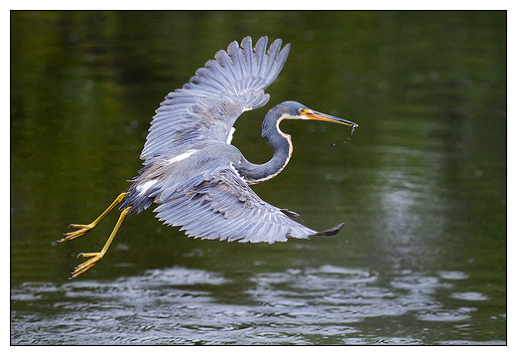

A boy jumps off a tan rock .
This image is unavailable in your country in compliance with local laws
The man is dressed in black and smiling while another man is drinking and an elderly woman is standing near a fence .
Proximity: [6.767214e-24]


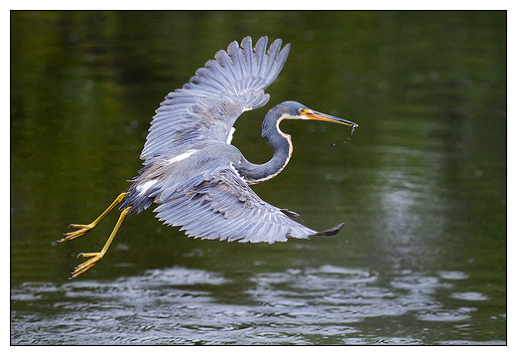

A woman poses for a picture while in front of a lake .
Proximity: [3.4854352e-29]


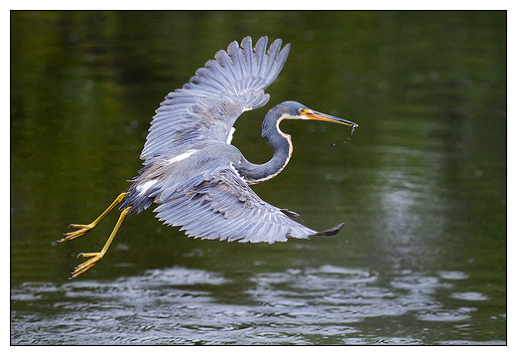

A little girl blows out the candles on her cake .
This image is unavailable in your country in compliance with local laws
People skate in an urban outdoor ice skating rink
Proximity: [3.2175584e-19]


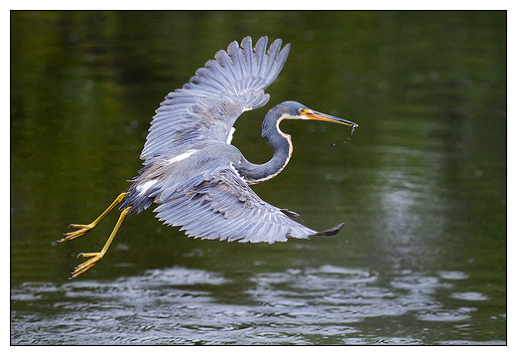

A man and a woman wear funny masks and pretend to smoke large , fake cigars .
Proximity: [6.4931343e-25]


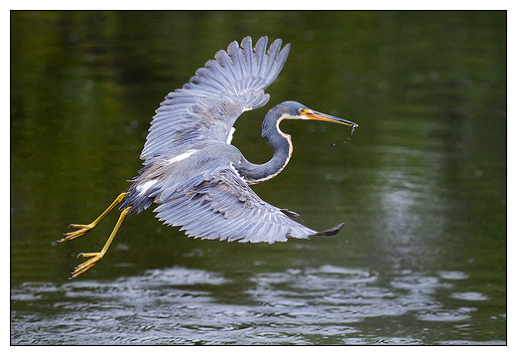

a guy and a girl jumping up in the air
This image is unavailable in your country in compliance with local laws
many people walk through the store .
Proximity: [9.114463e-21]


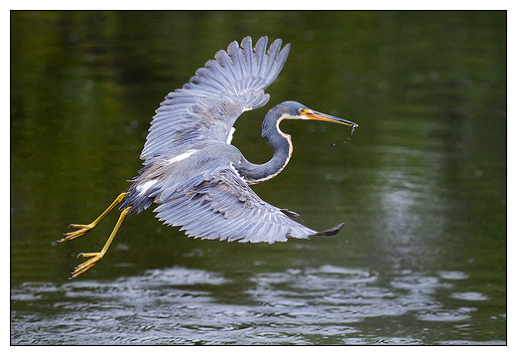

In [ ]:
#queries = np.array(test_queries.sample(n=images_size)['query_text'])
images = np.array(test_queries['image'])

for ind in rand_indices:
    query = test_queries.iloc[ind, :]['query_text']
    print(query)
    fname = get_image_from_query(embs_test[ind].cpu(), query, img_emb_info_test, images)
    if fname is None:
        print("This image is unavailable in your country in compliance with local laws")
    else:
        img = np.asarray(Image.open('test_images/' + fname))
        plt.imshow(img)
        plt.tick_params(left=False, bottom=False,
                   labelleft=False, labelbottom=False)
        plt.show()

### Выводы

Лучшей моделью оказалась полносвязная нейронная сеть. Результаты исследования показывают, что хотя и метрика, в целом, неплохая, но результаты оставляют желать лучшего. Скорее всего, здесь несколько причин: немного данных, нелучшее качество разметки (в основном).